In [1]:
!pip install -q scikit-learn folium scipy geopandas contextily

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import math
import folium
from folium.plugins import HeatMap
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from shapely.geometry import Point

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#read the CSV file with a comma delimiter
df = pd.read_csv("/content/drive/MyDrive/Praktikum_ML/praktikum11/data/taxi_data_subset.csv")

#cetak header data
df.head()

Unnamed: 0  DriveNo                  Date and Time  Longitude   Latitude
0           1      156  2014-02-01 00:00:00.739166+01  41.883672  12.487778
1           2      187  2014-02-01 00:00:01.148457+01  41.928543  12.469037
2           3      297  2014-02-01 00:00:01.220066+01  41.891069  12.492705
3           4       89  2014-02-01 00:00:01.470854+01  41.793177  12.432122
4           5       79  2014-02-01 00:00:01.631136+01  41.900275  12.462746

# **Inspeksi dan pembersihan awal**

In [6]:
# Pastikan kolom latitude/longitude punya nama yang konsisten
possible_lat = [c for c in df.columns if 'lat' in c.lower()]
possible_lon = [c for c in df.columns if 'lon' in c.lower() or 'lng' in c.lower()]
print('Candidates lat:', possible_lat)
print('Candidates lon:', possible_lon)

# Contoh penyesuaian: ganti sesuai nama di dataset
lat_col = possible_lat[0]
lon_col = possible_lon[0]

# Drop rows with missing coords
df = df.dropna(subset=[lat_col, lon_col]).reset_index(drop=True)


# Cast to float
df[lat_col] = df[lat_col].astype(float)
df[lon_col] = df[lon_col].astype(float)


print('After dropping NA:', df.shape)

Candidates lat: ['Latitude']
Candidates lon: ['Longitude']
After dropping NA: (10000, 5)


# **Visualisasi Awal**

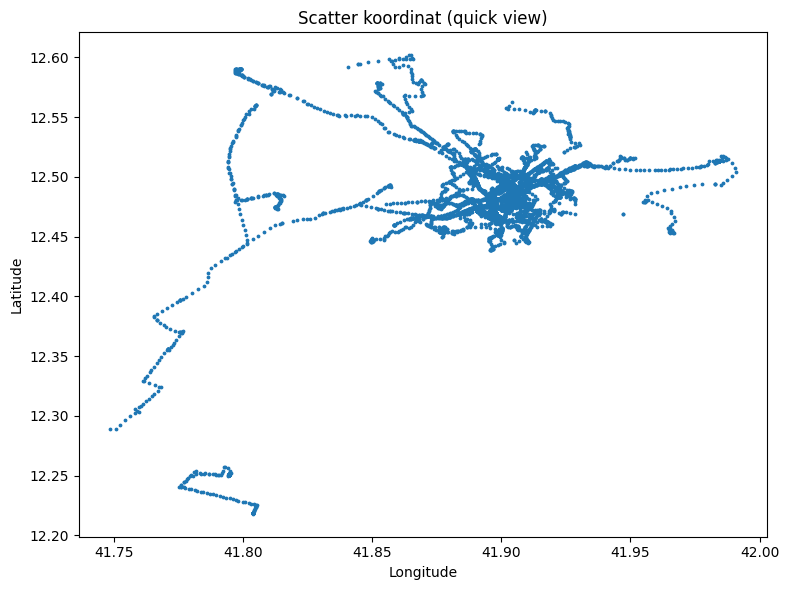

In [7]:
#check scatter plot awal (quick view)
plt.figure(figsize=(8,6))
plt.scatter(df[lon_col], df[lat_col], s=3)
plt.title('Scatter koordinat (quick view)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

# **Mempersiapkan data untuk DBSCAN**

In [8]:
# mempersiapkan data untuk DBSCAN (konversi ke radian jika pakai metric='haversine')
coords = df[[lat_col, lon_col]].to_numpy()
# untuk haversine, konversikan ke radian dan DBSCAN eps dalam radian
coords_rad = np.radians(coords)

# **Menentukan eps secara sistematis**

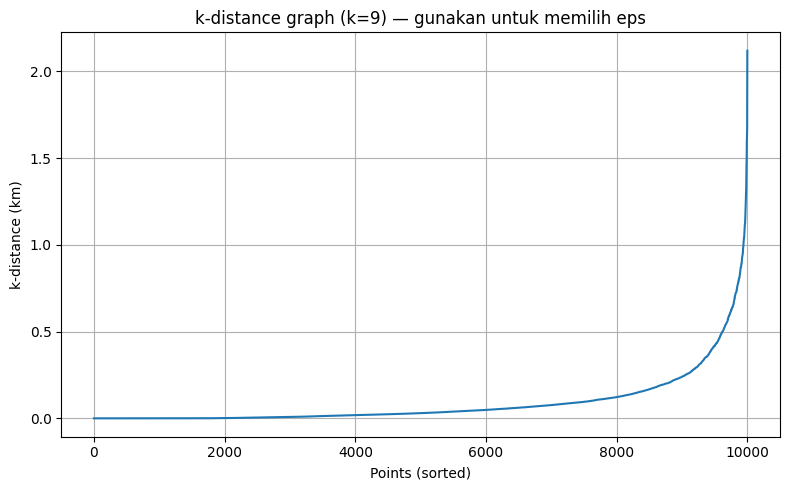

Median k-distance (km): 0.030075601057004756
90th percentile k-distance (km): 0.23929969086197728


In [9]:
#pilih k = min_samples - 1 (konvensi)
MIN_SAMPLES = 10
k = MIN_SAMPLES - 1
nbrs = NearestNeighbors(n_neighbors=k, metric='haversine').fit(coords_rad)
distances, indices = nbrs.kneighbors(coords_rad)
# Ambil jarak k-th nearest untuk setiap titik
k_distances = np.sort(distances[:, -1])


# Ubah ke satuan kilometer untuk interpretasi (earth radius ~6371 km)
EARTH_RADIUS_KM = 6371.0088
k_distances_km = k_distances * EARTH_RADIUS_KM


plt.figure(figsize=(8,5))
plt.plot(k_distances_km)
plt.ylabel('k-distance (km)')
plt.xlabel('Points (sorted)')
plt.title(f'k-distance graph (k={k}) — gunakan untuk memilih eps')
plt.grid(True)
plt.tight_layout()
plt.show()


print('Median k-distance (km):', np.median(k_distances_km))
print('90th percentile k-distance (km):', np.percentile(k_distances_km, 90))

# **pilih EPS**

In [10]:
# dari k-distance plot, tentukan eps_km
# gunakan nilai berdasarkan observasi k-distance graph
eps_km = 0.5
epsilon_radians = eps_km / EARTH_RADIUS_KM


print('eps_km chosen:', eps_km)
print('epsilon_radians:', epsilon_radians)

eps_km chosen: 0.5
epsilon_radians: 7.848050688613081e-05


# **Jalankan DBSCAN**

In [11]:
db = DBSCAN(eps=epsilon_radians, min_samples=MIN_SAMPLES, metric='haversine')
labels = db.fit_predict(coords_rad)


df['cluster'] = labels
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
noise_count = (labels == -1).sum()
print('Found clusters:', n_clusters)
print('Noise points:', noise_count, '(% {:.2f} %)'.format(noise_count/len(labels)*100))

Found clusters: 22
Noise points: 274 (% 2.74 %)


# **Statistik per cluster**

In [13]:
def cluster_stats(df, lat_col, lon_col):
    stats = []
    for c in sorted(df['cluster'].unique()):
        sub = df[df['cluster']==c]
        stats.append({
            'cluster': c,
            'count': len(sub),
            'lat_mean': sub[lat_col].mean(),
            'lon_mean': sub[lon_col].mean()
        })
    return pd.DataFrame(stats)


stats_df = cluster_stats(df, lat_col, lon_col)
stats_df = stats_df.sort_values('count', ascending=False).reset_index(drop=True)
stats_df

cluster  count   lat_mean   lon_mean
0         0   9016  12.482257  41.899456
1        -1    274  12.468719  41.841694
2         2    131  12.251065  41.793226
3        13     92  12.582620  41.803326
4        15     83  12.512993  41.983428
5         9     72  12.481414  41.808852
6        10     40  12.221070  41.803695
7        19     35  12.534065  41.926792
8         1     28  12.575909  41.852466
9        20     26  12.536677  41.885844
10        3     22  12.472279  41.836440
11        5     21  12.491131  41.855257
12       14     20  12.553142  41.862695
13       21     20  12.555095  41.913723
14        8     16  12.241821  41.777855
15       11     16  12.579913  41.868076
16        6     15  12.598809  41.861435
17       18     14  12.355840  41.770981
18       17     14  12.369950  41.774907
19        4     13  12.455526  41.965708
20       12     13  12.558393  41.804325
21       16     10  12.567934  41.866600
22        7      9  12.479372  41.847109

# **Visualisasi Klaster**

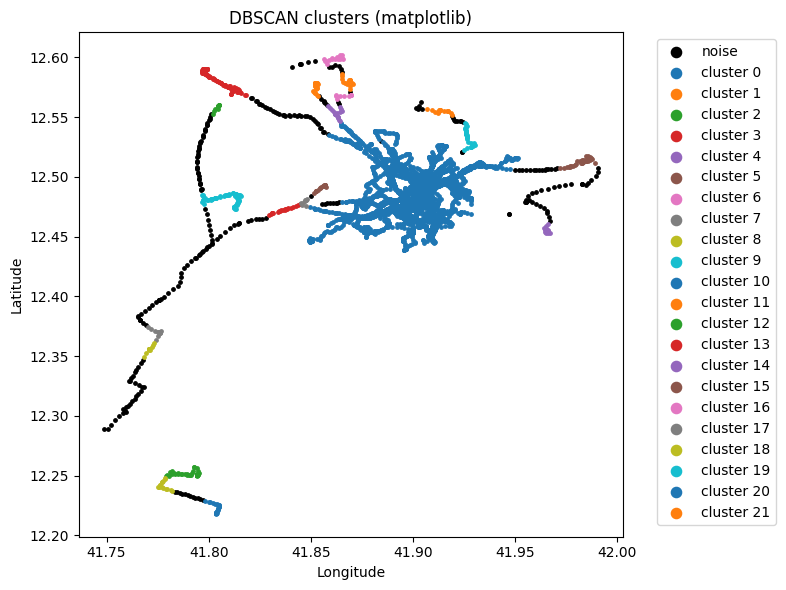

In [15]:
unique_labels = sorted(df['cluster'].unique())
colors = plt.cm.get_cmap('tab20', len(unique_labels))
plt.figure(figsize=(8,6))
for i, lab in enumerate(unique_labels):
    subset = df[df['cluster']==lab]
    if lab == -1:
        plt.scatter(subset[lon_col], subset[lat_col], s=6, c='k', label='noise')
    else:
        plt.scatter(subset[lon_col], subset[lat_col], s=6, label=f'cluster {lab}')
plt.legend(markerscale=3, bbox_to_anchor=(1.05,1))
plt.title('DBSCAN clusters (matplotlib)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

# **Peta Interaktif folium**

In [17]:
#pusat peta di mean koordinat
center = [df[lat_col].mean(), df[lon_col].mean()]
m = folium.Map(location=center, zoom_start=12)

# Warna sederhana per cluster
palette = ['red','blue','green','purple','orange','darkred','lightred','beige','darkblue','darkgreen','cadetblue','pink','lightblue','lightgreen','gray']


for idx, row in df.iterrows():
    lab = row['cluster']
    if lab == -1:
        color = 'black'
    else:
        color = palette[lab % len(palette)]
    folium.CircleMarker(location=[row[lat_col], row[lon_col]],
                        radius=2,
                        color=color,
                        fill=True,
                        fill_opacity=0.7,
                        weight=0).add_to(m)


# Add Heatmap layer
heat_data = df[[lat_col, lon_col]].values.tolist()
HeatMap(heat_data, radius=10, blur=15).add_to(m)


m